# Intoduction

The student will fine-tune an open-source multiligual NMT (mNMT) model for low-resource language pairs (LRL), such as English-Catalan.
Specifically, **back-translation** can be employed to augment a low-resource dataset (e.g. English-Catalan) with synthetic parallel data.
The translation performance of the fine-tuned model(s) should be compared against the original baseline using automatic evaluation metrics. For more information on mNMT, we direct the reader to **Chapter 16**.

We will be using the [NLLB](https://huggingface.co/facebook/nllb-200-distilled-600M) architecture for fine-tuning. Fine-tuning is a critical process where we take the model's weights, pre-trained on a vast, diverse corpus, and incrementally adjust them using our LRL parallel corpus. This procedure allows the NLLB model to better capture the unique stylistic, lexical, and grammatical of our LRL pair, improving its translation quality.

The Jupyter Notebook environment is the platform for generating and distributing documents that integrate live code, output, and explanatory text. For tasks in machine translation, it provides a streamlined, document-centric workspace ideal for rapid prototyping and experimentation. The architecture divides content into two primary components: documentation blocks (text/Markdown cells) for methodology descriptions and analysis interpretations, and execution blocks (code cells) for implementing and running NMT models and data processing routines (e.g., using Python).


## Questions

- Beyond automatic metrics scores (e.g. BLEU, chrF), what specific differences in translation output would you expect to see between the baseline, fine-tuned, and back-translation models, particularly in terms of accuracy, fluency, and terminology? For more information on manual evaluation, we direct the reader to **Chapter 10**.
- How might the performance observed when comparing the baseline, fine-tuned, and back-translation models shift when working with a LRL pair, and what unique challenges or opportunities might each approach present?
- Considering the computational resources and data requirements associated with each approach (baseline, fine-tuning, back-translation), given project constraints, how would you prioritise the use of one model over the others, based on automatic metrics scores?





# Install Libraries

To start the project, we must first install the required Python packages for our multilingual NMT workflow. We will specifically use resources like the Hugging Face Transformers library ([transformers](https://huggingface.co/docs/transformers/en/index)), which delivers state-of-the-art NMT models, allowing us to quickly implement, evaluate, and modify models without having to train them from scratch.

The installation of these packages will be executed using pip install [package_name] within the code cells.


In [ ]:
!pip install transformers[sentencepiece]==4.57.1
!pip install datasets==4.0.0
!pip install evaluate==0.4.6
!pip install accelerate==1.11.0 #0.29.3
!pip install sacrebleu==2.5.1  #==2.5.1
!pip install bitsandbytes==0.48.2
!pip install peft==0.17.1  #==0.7.1 #0.13.2

# Back-Translation


Back-translation is a highly effective data augmentation technique used in NMT to overcome the scarcity of parallel data, particularly for LRL.


Back-translation (BT) is a semi-supervised approach that leverages readily available monolingual data (text in a single language) to generate synthetic parallel data (aligned sentences in two languages).

The standard pipeline for a translation from Source (S) to Target (T) (e.g., English-Catalan) is as follows:

1. **Synthetic Data Generation**: A large corpus of monolingual data in the Target language ($D_T$, e.g., Catalan text) is collected.5 The reverse model ($M_{T \to S}$) translates this monolingual text back into the Source language (English).
2. **Corpus Augmentation**: The resulting sentence pairs—the original Catalan sentence and its newly translated English counterpart—form a synthetic parallel corpus. This synthetic data is then combined with the original, real parallel data
3. **Final Model Tuning**: The final model ($M_{S \to T}$, e.g., English-Catalan) is trained on the augmented (real + synthetic) parallel corpus.

Back-translation allows the final model to benefit from the Target language's fluency present in the large monolingual corpus.

The following image ilustrates the back-trasnlation pipeline. Image from [Iterative Back-Translation for Neural Machine Translation](https://aclanthology.org/W18-2703.pdf)

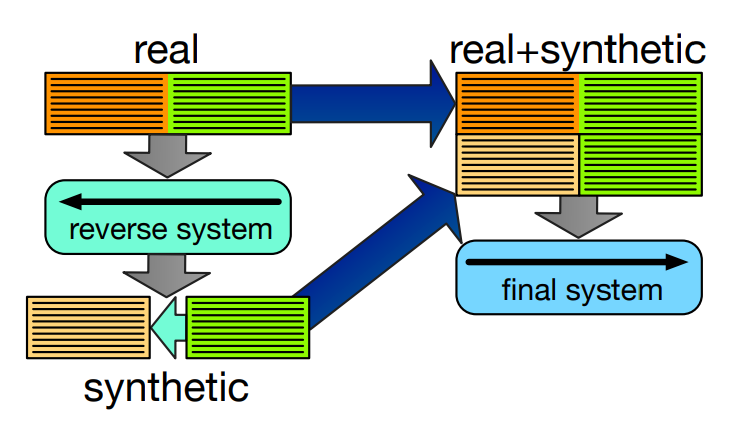

# 1 Synthetic Data Generation

Please upload the raw Catalan (monolingual: cat_ccMatrix_mono.txt) text files—which represent the language pair extracted from the CCMatrix as our corpus into the Colab file system. Use the file upload buttom (found in the sidebar) within the notebook interface. Once uploaded, the files will reside in a temporary storage, making them accessible via the local file path for our code.

In [ ]:
#1 Synthetic Data Generation
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import codecs

mt_output_file = "nllb-syn.en.txt"
mt_output = codecs.open(mt_output_file, 'w', 'utf-8')
#our reverse model is Catalan-Enlgish NLLB
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
mt_pipeline = pipeline(task="translation",
              model="facebook/nllb-200-distilled-600M" ,
              src_lang="cat_Latn",
              tgt_lang="eng_Latn",
              dtype=torch.float16,
              device=0,
              batch_size=12,
              forced_bos_token_id=tokenizer.convert_tokens_to_ids("eng_Latn"))

# we use monolingual Catalan segments form the CCMatrix corpus, which consists of several domains
file_name = "cat_ccMatrix_mono.txt"

with codecs.open(file_name, 'r', 'utf-8') as src:
  lines = []
  for line in src:
    line = line.strip()
    lines.append(line)
print(lines)
mt_lines = mt_pipeline(lines)
for line in mt_lines:
  print(line['translation_text'], file=mt_output)


mt_output.close()

In [ ]:
#delete model from mememory to free gpu
import gc
gc.collect()
torch.cuda.empty_cache()
del mt_pipeline

# 2 Corpus Augmentation

To proceed with the back-trasnlaiton pipeline, we have to upload our data. Please upload the raw English (source: *eng_Latn.dev*) and Catalan (target: *cat_Latn.dev*) text files—which represent the language pair extracted from the dev split of the [FLORES-200](https://github.com/facebookresearch/flores/tree/main/flores200) benchmark as our corpus into the Colab file system. Use the file upload buttom (found in the sidebar) within the notebook interface. Once uploaded, the files will reside in a temporary storage, making them accessible via the local file path for our code.

We will concatenate the original parallel corpus with the synthetic data.

In [ ]:
#2 Corpus Augmentation
#concatenate en + en syn
!cat eng_Latn.dev nllb-syn.en.txt > backtr_en.dev

In [ ]:
#concatenate cat + cat mono
!cat cat_Latn.dev cat_ccMatrix_mono.txt > backtr_cat.dev

In [ ]:
#count number of lines on each file to check if the parallel files are correctly aligned
!wc -l *

# 3 Final Model Tuning


The following block contains the code to fine-tune the [NLLB](https://huggingface.co/docs/transformers/en/model_doc/nllb) model via [LoRA](https://huggingface.co/docs/transformers/en/peft) (Low-Rank Adaptation), which is an example of Parameter-Efficient Fine-Tuning (PEFT).
In addition, we will fine-tune NLLB model with the augmented parellel corpus from step 2.

Standard fine-tuning of a model as large as NLLB is computationally prohibitive, requiring significant GPU resources and storage. LoRA overcomes this challenge by focusing on the hypothesis that the 'update' required to specialize the pre-trained model for a new task (like our English-Catalan translation) within few parameters (matrices). By only training these new, small LoRA adapters (the low-rank matrices), we achieve effective transfer learning without the massive resource of updating every weight in the base NLLB model.

## Text Processing
To prepare the data for the mNMT model, we will perform a data preprocessing step: converting the augmented source language and target language text files into the JSON format. This conversion is necessary because many state-of-the-art NMT frameworks (like those in Hugging Face), require data to be structured in a specific, machine-readable format—often a list of dictionaries or similar JSON structure to facilitate efficient tokenization, batching, and loading by the model's data loader utility.


**Note**: Please pay attention to the in-line documentation. Explanations regarding the function, and specific NMT techniques employed within the code blocks are provided through Python comments, which are defined by the hash symbol (#). Reading these comments is important for understanding why specific steps are being taken in the NMT workflow.

In [ ]:
#txt to json
import sys
import json
import re
import codecs

# json from huggingface example output file:
#{ "translation": { "eng_Latn": "The pilot was identified as Squadron Leader Dilokrit Pattavee", "cat_Latn": "Es va identificar el pilot com el líder de l'esquadró Dilokrit Pattavee." } }
#{ "translation": { "eng_Latn": "Vettel, on the other hand, hasn't won since 2013, when he was a Red Bull driver.", "cat_Latn": "Vettel, en canvi, no hi guanya des del 2013, quan era pilot de Red Bull." } }
#...


def txt2json(src_id, trg_id, src_file, trg_file, out_file):
  """
  Read source and target files with utf-8 encoding
  and write into output json structured file
  """

  src = codecs.open(src_file, 'r', encoding="utf-8")
  trg = codecs.open(trg_file, 'r', encoding="utf-8")
  out_json = codecs.open(out_file, 'w', encoding="utf-8")


  src_lines = []
  trg_lines = []
  for line_s, line_t in zip(src, trg):
      line_s = line_s.strip()
      line_t = line_t.strip()
      src_lines.append(line_s)
      trg_lines.append(line_t)
  recs = [src_lines, trg_lines]
  for src, tgt in zip(*recs):
      out = {"translation": { src_id: src, trg_id: tgt } }
      x = json.dumps(out, indent=0, ensure_ascii=False)
      x = re.sub(r'\n', ' ', x, 0, re.M)
      out_json.write(x + "\n")
  out_json.close()
  return

In [ ]:
#we will use the augmented parellel corpus for fine-tuning our mNMT model
#https://github.com/facebookresearch/flores/tree/main/flores200
train_src = "backtr_en.dev"
train_trg = "backtr_cat.dev"
train_json = "en-cat.backtr.train.json"

txt2json('eng_Latn', 'cat_Latn', train_src, train_trg, train_json)

In [ ]:
#import required libraries into code
import torch
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    MBartTokenizer,
    MBart50Tokenizer,
    MBartTokenizerFast,
    MBart50TokenizerFast,
    M2M100Tokenizer,
    NllbTokenizerFast,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed,
)
from datasets import load_dataset, DatasetDict
from evaluate import load
import transformers
import os
import numpy as np
from transformers import BitsAndBytesConfig
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

MODEL_CONFIG_CLASSES = list(MODEL_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)
MULTILINGUAL_TOKENIZERS = [MBartTokenizer, MBartTokenizerFast, MBart50Tokenizer, MBart50TokenizerFast, M2M100Tokenizer, NllbTokenizerFast]
model = None

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def main(model_id,max_length, source_code,
     target_code, forced_bos_token,
     data_files, output_dir, train_bs,
     grad_acc, lr, w_steps, n_epoch,
     lr_scheduler_type,
     lora_r, lora_alpha, lora_dropout):

    #loads NLLB tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    #loads NLLB model into the GPU
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id,
                                                  device_map="auto") #{"": 0}



    # Sets decoder_start_token_id
    if model.config.decoder_start_token_id is None and isinstance(tokenizer, (MBartTokenizer, MBartTokenizerFast)):
      if isinstance(tokenizer, MBartTokenizer, MBartTokenizerFast):
          model.config.decoder_start_token_id = tokenizer.lang_code_to_id[target_code]
      else:
          model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(target_code)

    #set language id labels for the tokenizer, and for the beginning of the source sentence:
    #[cat_Latn] The black cat.
    if isinstance(tokenizer, tuple(MULTILINGUAL_TOKENIZERS)):

      tokenizer.src_lang = source_code
      tokenizer.tgt_lang = target_code

      # For multilingual translation models like mBART-50 and M2M100 we need to force the target language token
      # as the first generated token.
      forced_bos_token_id = (
          tokenizer.convert_tokens_to_ids(forced_bos_token) if forced_bos_token is not None else None
      )
      model.config.forced_bos_token_id = forced_bos_token_id


    #LoRA configuration:
    #r is the intrinsic rank of the update matrices.
    #Ranges from 4 to 256. Common starting points are 8, 16, or 32.
    #A higher r increases model capacity but also computational cost.
    #lora_alpha is the scaling factor applied to the adapted weights.
    #It determines the influence of the LoRA updates relative to the original, frozen pre-trained weights

    config = LoraConfig(r=lora_r,
                        lora_alpha=lora_alpha,
                        lora_dropout=lora_dropout, #0.05
                        inference_mode=False,
                        target_modules=["q_proj", "k_proj", "v_proj"],
                        task_type="SEQ_2_SEQ_LM")

    model = get_peft_model(model, config)

    print_trainable_parameters(model)
    print(model)
    #we use BLEU score for model selection
    metric = load('sacrebleu', trust_remote_code=True)

    def preprocess_parallel_function(examples):
      """
      Loads json file into memory and tokenizes each segment
      """
      inputs = [ex[source_code] for ex in examples["translation"]]
      targets = [ex[target_code] for ex in examples["translation"]]

      model_inputs = tokenizer(inputs, max_length=max_length, padding=False, truncation=True)


      labels = tokenizer(targets, max_length=max_length, padding=False, truncation=True)





      model_inputs["labels"] = labels["input_ids"]

      return model_inputs

    def postprocess_text(preds, labels):
      """
      prepares the model translations for the BLEU metric evaluation
      """
      preds = [pred.strip() for pred in preds]
      labels = [[label.strip()] for label in labels]

      return preds, labels

    def compute_metrics(eval_preds, ignore_pad_token_for_loss=False):
      """
      computes the BLEU score for the model
      """
      preds, labels = eval_preds
      if isinstance(preds, tuple):
        preds = preds[0]
      decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
      # Replace -100 in the labels as we can't decode them.
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
      decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
      # Some simple post-processing
      decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

      result = metric.compute(predictions=decoded_preds, references=decoded_labels)
      prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
      result = {'bleu' : result['score']}
      result["gen_len"] = np.mean(prediction_lens)
      result = {k: round(v, 4) for k, v in result.items()}
      return result
    #loads data into memory
    data = load_dataset("json", data_files=data_files)
    #splits data segments into training 90% and 10% validation for model selection
    # seed for reproducibility
    data_split = data['train'].train_test_split(test_size=0.025, seed=42)
    data = DatasetDict({'train': data_split['train'],
                        'valid': data_split['test']})


    print(data)
    #process data into batches of n segments at a time
    data = data.map(preprocess_parallel_function,
                    batched=True)
    label_pad_token_id = -100
    # model fine-tune configuration
    trainer = transformers.Seq2SeqTrainer(
        model=model,
        train_dataset=data["train"],
        eval_dataset=data["valid"],
        args=transformers.Seq2SeqTrainingArguments(
            report_to='none',  #turns off  wandb output visualization
            per_device_train_batch_size=train_bs,
            gradient_accumulation_steps=grad_acc,
            do_train=True,
            do_eval=True,
            per_device_eval_batch_size=6,
            eval_accumulation_steps=4, #flush inference memory from the gpu after 4 batches
            warmup_ratio=w_steps,
            lr_scheduler_type=lr_scheduler_type,
            num_train_epochs=n_epoch,
            predict_with_generate=True,
            metric_for_best_model='bleu',
            load_best_model_at_end=True,
            learning_rate=lr,
            save_total_limit=1,
            save_strategy="epoch",
            eval_strategy="epoch",
            output_dir=output_dir,
        ),
        data_collator=transformers.DataCollatorForSeq2Seq(tokenizer,
                                                          label_pad_token_id=label_pad_token_id,
                                                          model=model),
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )
    model.config.use_cache = False  # silences the warnings
    #excecutes training loop
    trainer.train()
    #saves fine-tuned model into output directory
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

# Model hyper-parameters

To perfom thw fine-tuning process and adapt the pre-trained NLLB model to our LRL pair, we must first define and configure several hyperparameters.

Hyperparameters are external configuration variables set before the training process begins, guiding how the learning will occur. Their tuning is essential for achieving optimal model performance and resource efficiency.

The main parameters we need to define include:

- Learning Rate: This controls the magnitude of the weight updates during optimization. Setting it too high can lead to unstable training, while setting it too low can result in slow convergence.
- Batch Size: This determines the number of training segments in one forward/backward pass. Larger batch sizes generally lead to more stable gradients but require significantly more GPU memory.
- Learning Rate Scheduler: This defines the policy for dynamically adjusting the learning rate over the course of training (e.g., linear decay with warmup steps), which is critical for smooth and effective convergence in deep learning.
- LoRA Configuration: Since we are using Parameter-Efficient Fine-Tuning (PEFT), we must also specify the LoRA-specific parameters, such as the Rank (r) and the Alpha, which control the model's capacity for adaptation and the strength of the updates.

In [ ]:
#fine-tune
# we are going to use the NLLB version with 600M parameters
model_id = "facebook/nllb-200-distilled-600M"
#you can also use a bigger model: facebook/nllb-200-1.3B
#double check the batch size
#the max size of a segment is 128 tokens
max_length = 128
#we define the source and target iso id based on the NLLB format
#for using different language pairs, please check:
# https://github.com/facebookresearch/flores/tree/main/flores200
source_code = 'eng_Latn' # English
target_code = 'cat_Latn' #Catalan
forced_bos_token = 'cat_Latn' #beggining of segment token
data_files = "en-cat.backtr.train.json" #input  json file with augmented corpus
output_dir = 'models/nllb-backtr-peft_finetune' #directory to save back-translation tuned model
train_bs = 12  #number of segments in a batch
grad_acc = 1#we wont use gradient accumulation, if the size of the batch is to big for gpu, reduce batch and increase gradient accumulation
# for more info: https://huggingface.co/docs/accelerate/en/usage_guides/gradient_accumulation
lr = 1e-4 #size of the lnearning rate
w_steps = 0.03 #size of the warm-up steps
n_epoch = 3 #number of epochs
lr_scheduler_type = "linear" #type of learning rate sheduler
lora_r = 16 #size r for LoRA
lora_alpha = 32  #size alphra for LoRA
lora_dropout = 0.1 #size of dropout for LoRA

# fine-tune NLLB model

main(model_id=model_id, max_length=max_length, source_code=source_code,
     target_code=target_code, forced_bos_token=forced_bos_token,
     data_files=data_files, output_dir=output_dir, train_bs=train_bs,
     grad_acc=grad_acc, lr=lr, w_steps=w_steps, n_epoch=n_epoch,
     lr_scheduler_type=lr_scheduler_type,
     lora_r=lora_r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)

# Test fine-tuned Back-Translation Model

We will use the English-Catalan devtest split of the FLORES-200 benchmark as our test set. It's crucial that this data has not been used during any prior training or validation steps to ensure an unbiased measure of quiality.

To facilitate translation, we will utilize the Hugging Face transformers pipeline. This allows us to rapidly generate Catalan translations for all English source segments using both models:

The Baseline Model (the original, pre-trained NLLB model).

The Back-translation tuned Model (the version adapted using synthetic data and LoRA on our specific LRL parallel corpus).

By running both models on the identical test set, we establish a direct, comparison to assess the quality added by our fine-tuning process.

In [ ]:
#Test translation with baseline NLLB model (inference)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel, PeftConfig
import codecs
#output file
mt_output_file = "nllb-distill.cat.txt"
mt_output = codecs.open(mt_output_file, 'w', 'utf-8')
#inference with model, on GPU, and a given batch size
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
mt_pipeline = pipeline(task="translation",
              model="facebook/nllb-200-distilled-600M" ,
              src_lang="eng_Latn",
              tgt_lang="cat_Latn",
              dtype=torch.float16,
              device=0,
              batch_size=6,
              forced_bos_token_id=tokenizer.convert_tokens_to_ids("cat_Latn"),)

#save translation into file
# we use the English devtest file for evaluation
file_name = "eng_Latn.devtest"
print(mt_pipeline)
with codecs.open(file_name, 'r', 'utf-8') as src:
  lines = []
  for line in src:
    line = line.strip()
    lines.append(line)
print(lines)
mt_lines = mt_pipeline(lines)
for line in mt_lines:
  print(line['translation_text'], file=mt_output)

mt_output.close()

In [ ]:
##Test translation with back-trasnlation tuned NLLB model (inference)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel, PeftConfig
import codecs

mt_output_file = "nllb-backtr_out.cat.txt"
mt_output = codecs.open(mt_output_file, 'w', 'utf-8')

peft_model_id = "models/nllb-backtr-peft_finetune" #path of your directory with the finetuned
#load LoRA adapter
config = PeftConfig.from_pretrained(peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(peft_model_id, src_lang="eng_Latn")
#print(config.base_model_name_or_path)
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path,
                                              device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

model.eval()

file_name = "eng_Latn.devtest"
#inference with fine-tuned model, on GPU, and a given batch size
mt_pipeline = pipeline(task="translation",
              model=model,
              tokenizer=tokenizer,
              src_lang="eng_Latn",
              tgt_lang="cat_Latn",
              dtype=torch.float16,
              batch_size=6,
              forced_bos_token_id=tokenizer.convert_tokens_to_ids("cat_Latn"),)

#save translation into file
# we use the English devtest file for evaluation
file_name = "eng_Latn.devtest"
print(mt_pipeline)
with codecs.open(file_name, 'r', 'utf-8') as src:
  lines = []
  for line in src:
    line = line.strip()
    lines.append(line)
print(lines)
mt_lines = mt_pipeline(lines)
for line in mt_lines:
  print(line['translation_text'], file=mt_output)

mt_output.close()

# Evaluation with Automatic Metrics

For an evaluation of our multilingual NMT model's performance, we will rely on the industry-standard [sacreBLEU](https://github.com/mjpost/sacrebleu) library.

We will use two metrics: BLEU (Bilingual Evaluation Understudy), which quantifies the n-gram overlap between the candidate and reference translations, and chrF (Character n-gram F-score), which is often a more reliable measure for morphologically rich languages (like Catalan) as it operates at the character level.

Crucially, to determine if the performance difference observed between models is a significant improvement rather than random variation, we will employ bootstrapping (specifically, paired bootstrap resampling). This statistical technique allows us to test the difference in scores, enabling us to measure statistical significance and the confidence of whether one model outperforms the other.

In [ ]:
#BLEU and chrf evaluation with baseline, fine-tuned model, and back-translation tuned model
!sacrebleu cat_Latn.devtest -l en-ca -i nllb.cat.txt nllb-peft_finetune_out.cat.txt nllb-backtr_out.cat.txt -f text -m bleu chrf --paired-bs

# Questions

- Beyond automatic metrics scores (e.g. BLEU, chrF), what specific differences in translation output would you expect to see between the baseline, fine-tuned, and back-translation models, particularly in terms of accuracy, fluency, and terminology? For more information on manual evaluation, we direct the reader to **Chapter 10**.
- How might the performance observed when comparing the baseline, fine-tuned, and back-translation models shift when working with a LRL pair, and what unique challenges or opportunities might each approach present?
- Considering the computational resources and data requirements associated with each approach (baseline, fine-tuning, back-translation), given project constraints, how would you prioritise the use of one model over the others, based on automatic metrics scores?

# Delete models to free memory

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
#del mt_pipeline
del model